<a href="https://colab.research.google.com/github/HelenLit/cat-or-dog_CNN/blob/main/cat_or_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this work I'm using the famous Cats vs Dogs dataset to train a model that can classify images of dogs from images of cats. For this, I created create my own Convolutional Neural Network in Tensorflow and leveraged Keras' image preprocessing utilities.

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

Now, I'll try to use the convolution layers of the InceptionV3 architecture as my base model.

In [2]:
# Downloading the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-08-27 14:32:40--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.121.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   158MB/s    in 0.5s    

2023-08-27 14:32:41 (158 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Downloading the dataset from its original source by running the cell below.

Zip file that contains the images is unzipped under the /tmp directory.

In [3]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-08-27 14:32:41--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.11.196.201, 2600:1407:5800:399::317f, 2600:1407:5800:3a7::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.11.196.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  60.5MB/s    in 10s     

2023-08-27 14:32:51 (78.6 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the /tmp/PetImages directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [4]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


`create_train_val_dirs` function creates subdirectories for training and validation data

In [5]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """
  train_dir = os.path.join(root_path, 'training')
  validation_dir = os.path.join(root_path, 'validation')

  # Directory with training cat/dog pictures
  train_cats_dir = os.path.join(train_dir, 'cats')
  train_dogs_dir = os.path.join(train_dir, 'dogs')

  # Directory with validation cat/dog pictures
  validation_cats_dir = os.path.join(validation_dir, 'cats')
  validation_dogs_dir = os.path.join(validation_dir, 'dogs')

  os.makedirs(train_dir)
  os.makedirs(train_cats_dir)
  os.makedirs(train_dogs_dir)

  os.makedirs(validation_dir)
  os.makedirs(validation_cats_dir)
  os.makedirs(validation_dogs_dir)

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [6]:
# Testing create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats


The `split_data` function takes in the following arguments:
- SOURCE_DIR: directory containing the files

- TRAINING_DIR: directory that a portion of the files will be copied to (will be used for training)
- VALIDATION_DIR: directory that a portion of the files will be copied to (will be used for validation)
- SPLIT_SIZE: determines the portion of images used for training.

The files is randomized, so that the training set is a random sample of the files, and the validation set is made up of the remaining files.

For example, if `SOURCE_DIR` is `PetImages/Cat`, and `SPLIT_SIZE` is .9 then 90% of the images in `PetImages/Cat` will be copied to the `TRAINING_DIR` directory
and 10% of the images will be copied to the `VALIDATION_DIR` directory.

All images are checked before the copy, so if they have a zero file length, they will be omitted from the copying process. In this case function prints out a message such as `"filename is zero length, so ignoring."`.


In [7]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """

  source_list = os.listdir(SOURCE_DIR)
  source_list = random.sample(source_list, len(source_list))

  if SPLIT_SIZE > 1.0:
    print("Split size = " + SPLIT_SIZE + ", but it should be less the 1.0 (100%)")
    return

  training_file_count = int(len(source_list)  * SPLIT_SIZE)

  for file in source_list:

    training_file_count -= 1
    file_path = os.path.join(SOURCE_DIR, file)

    if os.path.getsize(file_path) == 0.0:
      print(file + " is zero length, so ignoring.")
      continue

    if training_file_count >= 0:
      copyfile(file_path, os.path.join(TRAINING_DIR, file))
    else:
      copyfile(file_path, os.path.join(VALIDATION_DIR, file))

In [8]:
# Testing split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


Defining the callback:

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

A few pictures of what the cat and dog datasets look like.

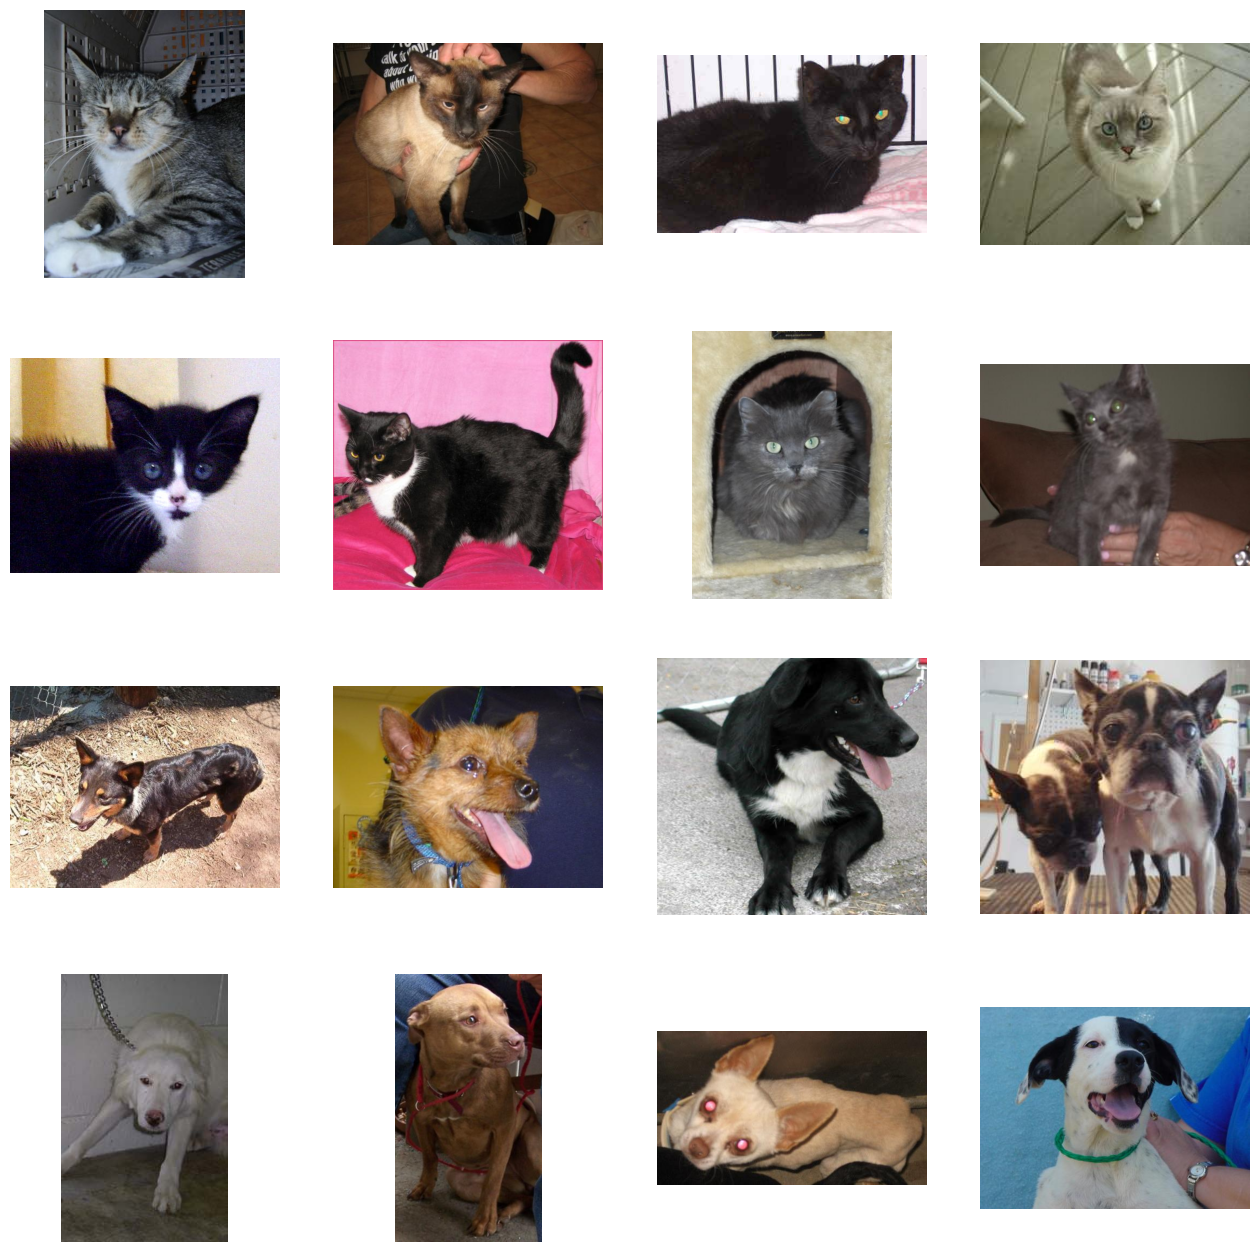

In [10]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

train_cat_fnames = os.listdir( TRAINING_CATS_DIR )
train_dog_fnames = os.listdir( TRAINING_DOGS_DIR )

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(TRAINING_CATS_DIR, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join(TRAINING_DOGS_DIR, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

`train_val_generators` function below creates generators that will yield batches of images, both for training and validation.

In [11]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, I also rotate and do other operations
  train_datagen = ImageDataGenerator(rescale=1.0/255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=128,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator(rescale=1.0/255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=128,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [12]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Defining the architecture of the model that will be trained in the `create_model` function below which should return a Keras' `Sequential` model.

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model


def create_model():

  # Set the weights file you downloaded into a variable
  local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

  # Initializing the base model.
  # Set the input shape and remove the dense layers.
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

  # Load the pre-trained weights you downloaded.
  pre_trained_model.load_weights(local_weights_file)

  # Freeze the weights of the layers.
  for layer in pre_trained_model.layers:
    layer.trainable = False

  # Choose `mixed7` as the last layer of your base model
  last_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_layer.output_shape)
  last_output = last_layer.output

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense  (1, activation='sigmoid')(x)

  # Append the dense network to the base model
  model = Model(pre_trained_model.input, x)

  model.compile(optimizer=RMSprop(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

Training my model.

**Note:** I ignored the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [14]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=myCallback())

last layer output shape:  (None, 7, 7, 768)
Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.9063

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


176/176 [==============================] - 178s 929ms/step - loss: 0.2387 - accuracy: 0.9063 - val_loss: 0.1045 - val_accuracy: 0.9600
Epoch 2/20
176/176 [==============================] - 160s 910ms/step - loss: 0.1503 - accuracy: 0.9360 - val_loss: 0.0732 - val_accuracy: 0.9700
Epoch 3/20
176/176 [==============================] - 160s 910ms/step - loss: 0.1380 - accuracy: 0.9419 - val_loss: 0.0665 - val_accuracy: 0.9716
Epoch 4/20
176/176 [==============================] - 161s 913ms/step - loss: 0.1312 - accuracy: 0.9443 - val_loss: 0.0625 - val_accuracy: 0.9752
Epoch 5/20
176/176 [==============================] - 160s 910ms/step - loss: 0.1225 - accuracy: 0.9490 - val_loss: 0.0630 - val_accuracy: 0.9756
Epoch 6/20
176/176 [==============================] - 164s 931ms/step - loss: 0.1182 - accuracy: 0.9514 - val_loss: 0.0618 - val_accuracy: 0.9744
Epoch 7/20
176/176 [==============================] - 158s 898ms/step - loss: 0.1157 - accuracy: 0.9517 - val_loss: 0.0643 - val_accura

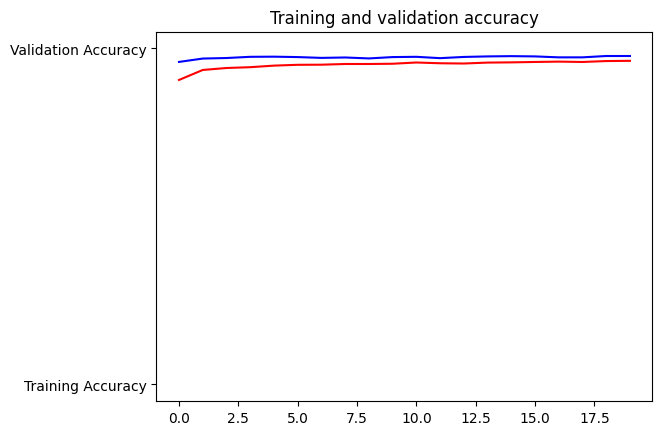

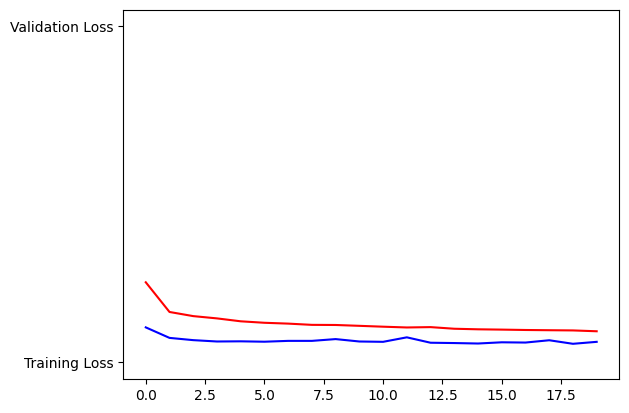

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()